In [1]:
import torch
import os
from torch.utils.data import DataLoader
import logging
import time
from tqdm import tqdm
from timm.utils import AverageMeter
import numpy as np
import argparse
import sys

sys.path.insert(0, "/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/")
from dataset.dataset_imputation import PRE8dDataset
from utils import check_dir, masked_mae, masked_mse, seed_everything
from model.graphdiffusion import IAP_base

/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='PRE', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args([])
if config.area=="MEXICO":
    config.height, config.width = 36, 120
elif config.area=="PRE":
    config.height, config.width = 60, 96
elif config.area=="Chesapeake":
    config.height, config.width = 60, 48
elif config.area=="Yangtze":
    config.height, config.width = 96, 72
else:
    print("Not Implement")

In [3]:
device = "cuda"
train_dataset = PRE8dDataset(config)
train_dloader = DataLoader(train_dataset, config.batch_size, shuffle=True, prefetch_factor=2, num_workers=2)
test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).float().to(device)
low_bound = torch.from_numpy(train_dataset.min).float().to(device)
high_bound = torch.from_numpy(train_dataset.max).float().to(device)
model = IAP_base(config, low_bound, high_bound)

In [4]:
datas, data_ob_masks, data_gt_masks, labels, label_masks = next(iter(test_dloader))
datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)

In [5]:
model.load_state_dict(torch.load("/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/log/imputation/PRE/GraphDiffusion/best_0.1.pt").state_dict())

<All keys matched successfully>

In [6]:
model = model.to(device)
samples = model.impute_with_process(datas, data_ob_masks, adj, config.num_samples)

In [11]:
print(samples.shape)
print(datas.shape)

torch.Size([1, 50, 10, 46, 1, 4443])
torch.Size([1, 46, 1, 4443])


tensor([0.1950, 0.0000, 0.0000, 0.0000, 0.0000, 0.2418, 0.0000, 0.2867, 0.0000,
        0.1554, 0.2736, 0.0000, 0.3194, 0.0000, 0.2827, 0.2547, 0.2704, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3273, 0.3029, 0.3070, 0.3359, 0.2435,
        0.3246, 0.2749, 0.2604, 0.2692, 0.0000, 0.0000, 0.0000, 0.2110, 0.0000,
        0.1368, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3078,
        0.0000])


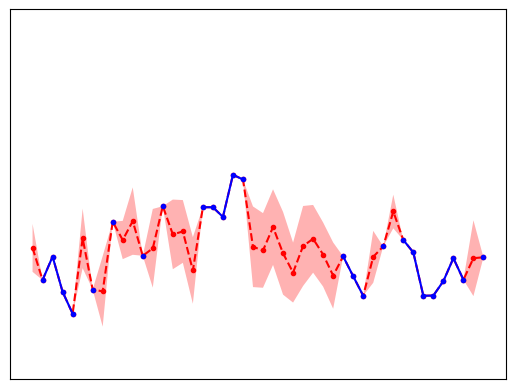

In [52]:
import copy
import matplotlib.pyplot as plt
t = 14
n = 3100
imputed_datas = copy.deepcopy(samples[0, t, :, :, 0, n])
oral_datas = copy.deepcopy(datas[0, :, 0, n])
oral_masks = copy.deepcopy(data_ob_masks[0, :, 0, n])

mean = torch.median(imputed_datas.cpu(), 0).values * (1-oral_masks.cpu()) + oral_masks.cpu() * oral_datas.cpu()
std = imputed_datas.cpu().std(0)*(1-oral_masks.cpu())
print(std)
std[oral_masks.bool()]=0
timestep = np.arange(oral_datas.shape[0])
oral_datas[~oral_masks.bool()]=np.nan
plt.plot(timestep, mean, color='Red',  linestyle='--',marker='.', label="1")
plt.fill_between(timestep, mean-std, mean+std, facecolor='Red', alpha=0.3)
plt.plot(timestep, oral_datas.cpu(), color='Blue',  marker='.', label="1")
plt.ylim(-1.5,1.5)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1850, 0.0000, 0.0000, 0.1260, 0.0000, 0.0000, 0.2435, 0.0000, 0.0000,
        0.0000, 0.1674, 0.0000, 0.0000, 0.1909, 0.2306, 0.1665, 0.1969, 0.1250,
        0.1978, 0.1826, 0.0000, 0.0000, 0.0000, 0.1762, 0.1070, 0.1944, 0.0000,
        0.1545, 0.1522, 0.0000, 0.0000, 0.1938, 0.2407, 0.0000, 0.0000, 0.0000,
        0.0000])


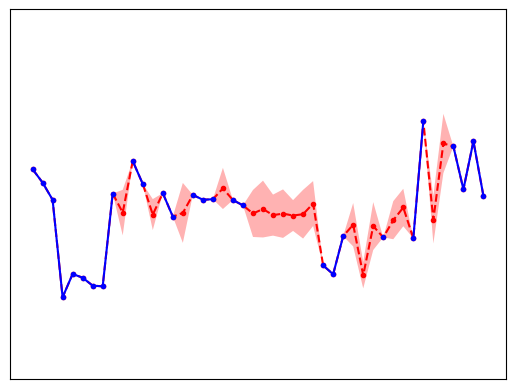

In [24]:
import copy
import matplotlib.pyplot as plt
t = 10
imputed_datas = copy.deepcopy(samples[0, t, :, :, 0, n])
oral_datas = copy.deepcopy(datas[0, :, 0, n])
oral_masks = copy.deepcopy(data_ob_masks[0, :, 0, n])

mean = imputed_datas.cpu().mean(0)*(1-oral_masks.cpu()) + oral_masks.cpu() * oral_datas.cpu()
std = imputed_datas.cpu().std(0)*(1-oral_masks.cpu())
print(std)
std[oral_masks.bool()]=0
timestep = np.arange(oral_datas.shape[0])
oral_datas[~oral_masks.bool()]=np.nan
plt.plot(timestep, mean, color='Red',  linestyle='--',marker='.', label="1")
plt.fill_between(timestep, mean-std, mean+std, facecolor='Red', alpha=0.3)
plt.plot(timestep, oral_datas.cpu(), color='Blue',  marker='.', label="1")
plt.ylim(-1.5,1.5)
plt.xticks([], [])
plt.yticks([], [])
plt.show()